# Transfer Learning Part 3: Scaling Up

We've seen the power of the transfer learning feature extraction and fine-tuning in the previous notebook, now it's time to scaling up to all classes Food101

Our goal is beat the original Food101 paper with %10 training data.
Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is %50.76 accuracy across 101 classes.

In [ ]:
# Import necessary libraries
import os
import datetime
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import warnings
import itertools

warnings.filterwarnings('ignore')

print(tf.__version__)

2.12.0


## 101 Food Classes: Working with less data (%10 percent)

Let's download the %10 percent of Food101 data with all classes.

In [ ]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the data
zip_ref = zipfile.ZipFile('101_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-17 16:57:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  34.0MB/s    in 43s     

2023-07-17 16:58:24 (36.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Create the train and test dir
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [ ]:
# How many classes/images are there?
for dir in os.walk('101_food_classes_10_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '101_food_classes_10_percent'
There are 101 directories and 0 images in '101_food_classes_10_percent/train'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'
There are 0 director

In [ ]:
# Setup data inputs
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print('Training data:')
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE)
print('\n')
print('Test data:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False) # dont shuffle test data for prediction analysis

Training data:
Found 7575 files belonging to 101 classes.


Test data:
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on %10 of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboed-model
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on %15 of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         monitor='val_accuracy')

In [ ]:
# Create a data augmentation layer
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name='data_augmentation')

In [ ]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# Summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
model_history = model.fit(train_data_all_10_percent,
                          epochs=5,
                          validation_data=test_data,
                          validation_steps=(0.15*len(test_data)), # %15 of test data
                          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 113s 408ms/step - loss: 3.3917 - accuracy: 0.2688 - val_loss: 2.5963 - val_accuracy: 0.4212
Epoch 2/5
237/237 [==============================] - 77s 324ms/step - loss: 2.2177 - accuracy: 0.4866 - val_loss: 2.1242 - val_accuracy: 0.4863
Epoch 3/5
237/237 [==============================] - 65s 270ms/step - loss: 1.8480 - accuracy: 0.5582 - val_loss: 1.9265 - val_accuracy: 0.5223
Epoch 4/5
237/237 [==============================] - 62s 258ms/step - loss: 1.6363 - accuracy: 0.5971 - val_loss: 1.8717 - val_accuracy: 0.5192
Epoch 5/5
237/237 [==============================] - 58s 241ms/step - loss: 1.4855 - accuracy: 0.6355 - val_loss: 1.7878 - val_accuracy: 0.5391


In [ ]:
# Evaluate the model with all test data
model_results = model.evaluate(test_data)
model_results

790/790 [==============================] - 58s 73ms/step - loss: 1.5798 - accuracy: 0.5846


[1.5798416137695312, 0.5846336483955383]

In [ ]:
# Create a function to plot loss and accuracy
def plot_loss_curves(history):

    '''
    Plot the loss and accuracy curves for training and validation parts.

    Args:
        history: TensorFlow history object.
    Returns:
        Loss and accuracy curves for training and validation
    '''

    # Convert history to dataframe
    dataframe = pd.DataFrame(history.history)
    dataframe = dataframe.set_index(pd.Index(range(1, len(dataframe) + 1)))

    # Set the plot size
    plt.figure(figsize=(12, 5))

    # Plot train and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(dataframe['loss'], 'b', label='Train loss')
    plt.plot(dataframe['val_loss'], 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(dataframe['accuracy'], 'b', label='Train accuracy')
    plt.plot(dataframe['val_accuracy'], 'r', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    # Adjust spaces and plot
    plt.subplots_adjust(wspace=0.3)
    plt.show()

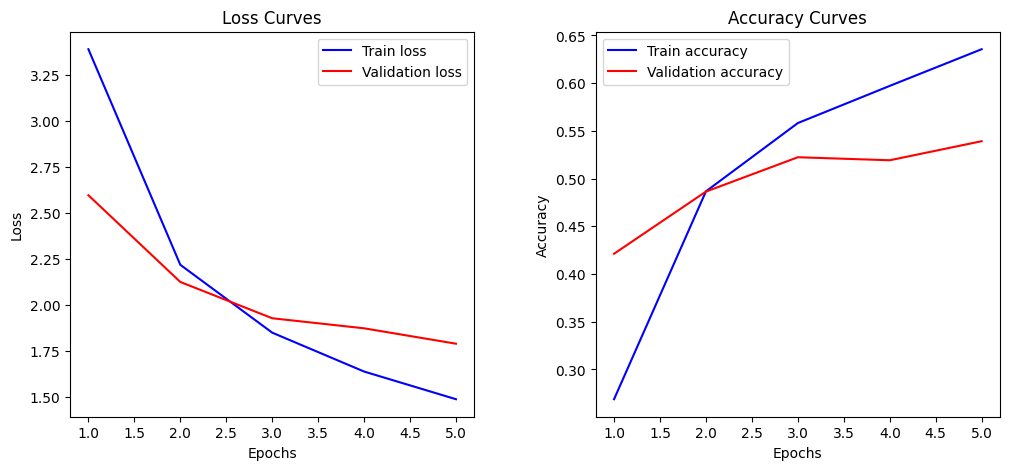

In [ ]:
# Plot loss curves
plot_loss_curves(model_history)

Its look our model performed to well on train data and not generalizing to unseen data. (Overfitting)

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
# Check out the layers
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [ ]:
# Recompile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Set the fine tune epoch
fine_tune_epochs = len(model_history.epoch) + 5

# Fit the model
model_fine_tuning_history = model.fit(train_data_all_10_percent,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      initial_epoch=model_history.epoch[-1],
                                      callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 65s 232ms/step - loss: 1.2536 - accuracy: 0.6657 - val_loss: 1.7537 - val_accuracy: 0.5418
Epoch 6/10
237/237 [==============================] - 47s 197ms/step - loss: 1.1488 - accuracy: 0.6953 - val_loss: 1.7678 - val_accuracy: 0.5421
Epoch 7/10
237/237 [==============================] - 49s 203ms/step - loss: 1.0625 - accuracy: 0.7158 - val_loss: 1.7302 - val_accuracy: 0.5495
Epoch 8/10
237/237 [==============================] - 45s 190ms/step - loss: 0.9837 - accuracy: 0.7352 - val_loss: 1.7063 - val_accuracy: 0.5546
Epoch 9/10
237/237 [==============================] - 47s 195ms/step - loss: 0.9341 - accuracy: 0.7480 - val_loss: 1.7038 - val_accuracy: 0.5559
Epoch 10/10
237/237 [==============================] - 45s 188ms/step - loss: 0.8764 - accuracy: 0.7634 - val_loss: 1.6820 - val_accuracy: 0.5628


In [ ]:
# Evaluate on the whole test data
fine_tuned_results = model.evaluate(test_data)
fine_tuned_results

790/790 [==============================] - 61s 77ms/step - loss: 1.4825 - accuracy: 0.6071


[1.482463002204895, 0.6071287393569946]

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epoch=5):
    '''
    Compares two Tensorflow history objects
    '''
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine original history with new history metrics
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    val_total_acc = val_acc + new_history.history['val_accuracy']
    val_total_loss = val_loss + new_history.history['val_loss']

    # Make plots for accuracy and loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training accuracy')
    plt.plot(val_total_acc, label='Validation accuracy')
    plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
    plt.title('Accuracy curves')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training loss')
    plt.plot(val_total_loss, label='Validation loss')
    plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
    plt.title('Loss curves')
    plt.legend()
    plt.show()

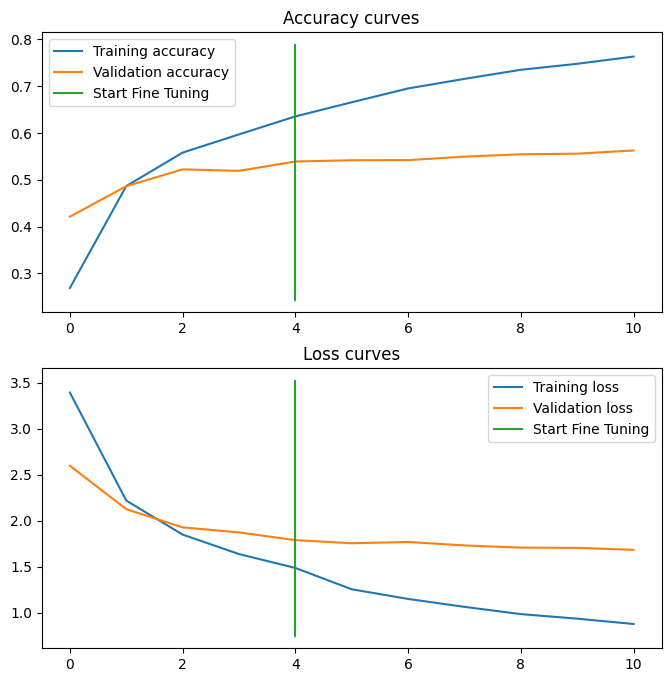

In [ ]:
# Compare the histories of feature extraction model and fine tuned model
compare_histories(model_history, model_fine_tuning_history)

Training loss and accuracy is performed well but validation metrics is not so its obvious this is overfitting.

## Make predictions with our trained model

Let's make some predictions, visualize them and then later find out which predictions were the 'most' wrong.

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 63s 78ms/step


In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# What the shapes of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like?
preds_probs[:10]

array([[2.40014911e-01, 2.33939150e-04, 1.17190264e-01, ...,
        9.60627767e-06, 3.06160422e-03, 2.96543688e-02],
       [9.38398838e-01, 2.68749698e-08, 1.29203149e-03, ...,
        3.68857570e-03, 6.08060873e-07, 8.97491373e-06],
       [4.67938185e-01, 9.90000740e-03, 3.58565301e-02, ...,
        6.05517649e-04, 4.49178187e-04, 6.21330133e-03],
       ...,
       [3.17428410e-01, 6.78706601e-06, 1.76846271e-03, ...,
        8.87460187e-02, 4.94584907e-04, 1.05939813e-04],
       [1.22775786e-01, 4.54468100e-04, 2.78991014e-01, ...,
        2.22164279e-04, 9.56307995e-05, 3.36267782e-04],
       [6.30524993e-01, 9.16671070e-07, 3.62354843e-03, ...,
        4.27965028e-03, 2.17495085e-06, 1.74090778e-03]], dtype=float32)

In [ ]:
# Let's see the first predictions
preds_probs[0], len(preds_probs[0])

(array([2.40014911e-01, 2.33939150e-04, 1.17190264e-01, 3.72580303e-07,
        7.77782134e-06, 2.43686577e-06, 1.25633902e-04, 3.23707832e-06,
        1.52782975e-02, 6.59162819e-04, 7.38519134e-07, 1.32561709e-05,
        6.94409769e-04, 6.31233661e-07, 1.12216212e-02, 6.47603488e-03,
        2.36200303e-05, 1.58916961e-03, 1.01347016e-02, 4.92623030e-06,
        8.50633369e-04, 2.14028114e-05, 1.22796657e-04, 9.98820644e-04,
        5.22616412e-03, 1.02520001e-03, 1.25126494e-03, 1.00920894e-04,
        2.74191380e-01, 3.78297851e-03, 4.03475315e-06, 2.53035501e-03,
        5.16403350e-04, 1.63434072e-06, 1.29147638e-02, 3.80785932e-05,
        2.33023762e-04, 1.61898707e-03, 6.04609922e-02, 4.53612010e-05,
        7.73267588e-04, 2.48362496e-03, 5.52691112e-04, 2.98905961e-05,
        3.86237298e-05, 3.76964235e-05, 1.13463809e-03, 1.60754571e-04,
        2.40110467e-06, 3.17692421e-02, 3.18398204e-04, 3.63645726e-04,
        3.76567394e-02, 1.04868002e-02, 8.47127594e-05, 6.564224

In [ ]:
# We get one prediction probability per class (in our case there are 101 prediction probabilities)
print(f'Number of prediction probabilities for sample 0: {len(preds_probs[0])}')
print(f'The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
The class with the highest predicted probability by the model for sample 0: 28


In [ ]:
# Get tge ored classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([28,  0,  0,  8,  8, 78, 29,  0,  9,  0])

In [ ]:
# How many pred classes we have?
len(pred_classes)

25250

Now, we got the prediction arrays of all of model's predictions, to evaluate them, we need to compare them to the orihjinal test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

y_labels[:10] # look at the first 10 label

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating models predictions

One way to check our model predictions array is in the same order as our test labels arrays is to find the accuracy score.

In [ ]:
# Remind the model accuracy
fine_tuned_results

[1.482463002204895, 0.6071287393569946]

In [ ]:
# Let's try scikit-learn's accuracy score funtion and see what it comes up
from sklearn.metrics import accuracy_score, confusion_matrix
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6071287128712871

Got the same results! Well.

## Let's get visual: making a confusion matrix

In [ ]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """
  Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Make a confusion matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=10)

## Let's keep the evaluation train going, time for a classification report
Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and f1) called classification report.

In [ ]:
# Import classification report from sklearn
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.38      0.16      0.22       250
           1       0.50      0.72      0.59       250
           2       0.60      0.65      0.62       250
           3       0.74      0.60      0.67       250
           4       0.57      0.45      0.50       250
           5       0.49      0.44      0.46       250
           6       0.74      0.76      0.75       250
           7       0.87      0.76      0.81       250
           8       0.26      0.57      0.36       250
           9       0.33      0.76      0.46       250
          10       0.50      0.40      0.44       250
          11       0.83      0.55      0.66       250
          12       0.62      0.68      0.65       250
          13       0.64      0.50      0.56       250
          14       0.65      0.48      0.55       250
          15       0.39      0.36      0.37       250
          16       0.64      0.61      0.62       250
          17       0.35    

The numbers above give a great class-by-class evaluation of model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [ ]:
# Get a dictionary of the classification report?
class_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
class_report_dict

{'0': {'precision': 0.37735849056603776,
  'recall': 0.16,
  'f1-score': 0.2247191011235955,
  'support': 250},
 '1': {'precision': 0.5027777777777778,
  'recall': 0.724,
  'f1-score': 0.5934426229508197,
  'support': 250},
 '2': {'precision': 0.5977859778597786,
  'recall': 0.648,
  'f1-score': 0.6218809980806141,
  'support': 250},
 '3': {'precision': 0.7438423645320197,
  'recall': 0.604,
  'f1-score': 0.6666666666666666,
  'support': 250},
 '4': {'precision': 0.5714285714285714,
  'recall': 0.448,
  'f1-score': 0.5022421524663677,
  'support': 250},
 '5': {'precision': 0.48660714285714285,
  'recall': 0.436,
  'f1-score': 0.459915611814346,
  'support': 250},
 '6': {'precision': 0.7431906614785992,
  'recall': 0.764,
  'f1-score': 0.7534516765285996,
  'support': 250},
 '7': {'precision': 0.8669724770642202,
  'recall': 0.756,
  'f1-score': 0.8076923076923077,
  'support': 250},
 '8': {'precision': 0.26394052044609667,
  'recall': 0.568,
  'f1-score': 0.3604060913705584,
  'support

Let's plot all of our classes F1-scores.

In [ ]:
class_report_dict['0']['f1-score']

0.2247191011235955

In [ ]:
# Create an empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in class_report_dict.items():
    if k == 'accuracy':
        break
    class_f1_scores[test_data.class_names[int(k)]] = round(v['f1-score'], 2)

class_f1_scores

{'apple_pie': 0.22,
 'baby_back_ribs': 0.59,
 'baklava': 0.62,
 'beef_carpaccio': 0.67,
 'beef_tartare': 0.5,
 'beet_salad': 0.46,
 'beignets': 0.75,
 'bibimbap': 0.81,
 'bread_pudding': 0.36,
 'breakfast_burrito': 0.46,
 'bruschetta': 0.44,
 'caesar_salad': 0.66,
 'cannoli': 0.65,
 'caprese_salad': 0.56,
 'carrot_cake': 0.55,
 'ceviche': 0.37,
 'cheese_plate': 0.62,
 'cheesecake': 0.41,
 'chicken_curry': 0.52,
 'chicken_quesadilla': 0.63,
 'chicken_wings': 0.73,
 'chocolate_cake': 0.54,
 'chocolate_mousse': 0.34,
 'churros': 0.7,
 'clam_chowder': 0.7,
 'club_sandwich': 0.68,
 'crab_cakes': 0.36,
 'creme_brulee': 0.78,
 'croque_madame': 0.7,
 'cup_cakes': 0.74,
 'deviled_eggs': 0.75,
 'donuts': 0.75,
 'dumplings': 0.84,
 'edamame': 0.97,
 'eggs_benedict': 0.74,
 'escargots': 0.7,
 'falafel': 0.42,
 'filet_mignon': 0.38,
 'fish_and_chips': 0.7,
 'foie_gras': 0.33,
 'french_fries': 0.73,
 'french_onion_soup': 0.69,
 'french_toast': 0.51,
 'fried_calamari': 0.62,
 'fried_rice': 0.55,
 'fr

In [ ]:
# Turn f1-scores into dataframe for visualization
f1_scores_df = pd.DataFrame({
    'class_name': list(class_f1_scores.keys()),
    'f1-score': list(class_f1_scores.values())
}).sort_values('f1-score', ascending=False)

f1_scores_df

class_name  f1-score
33           edamame      0.97
63          macarons      0.88
69           oysters      0.85
86           sashimi      0.84
32         dumplings      0.84
..               ...       ...
22  chocolate_mousse      0.34
82           ravioli      0.33
39         foie_gras      0.33
93             steak      0.31
0          apple_pie      0.22

[101 rows x 2 columns]

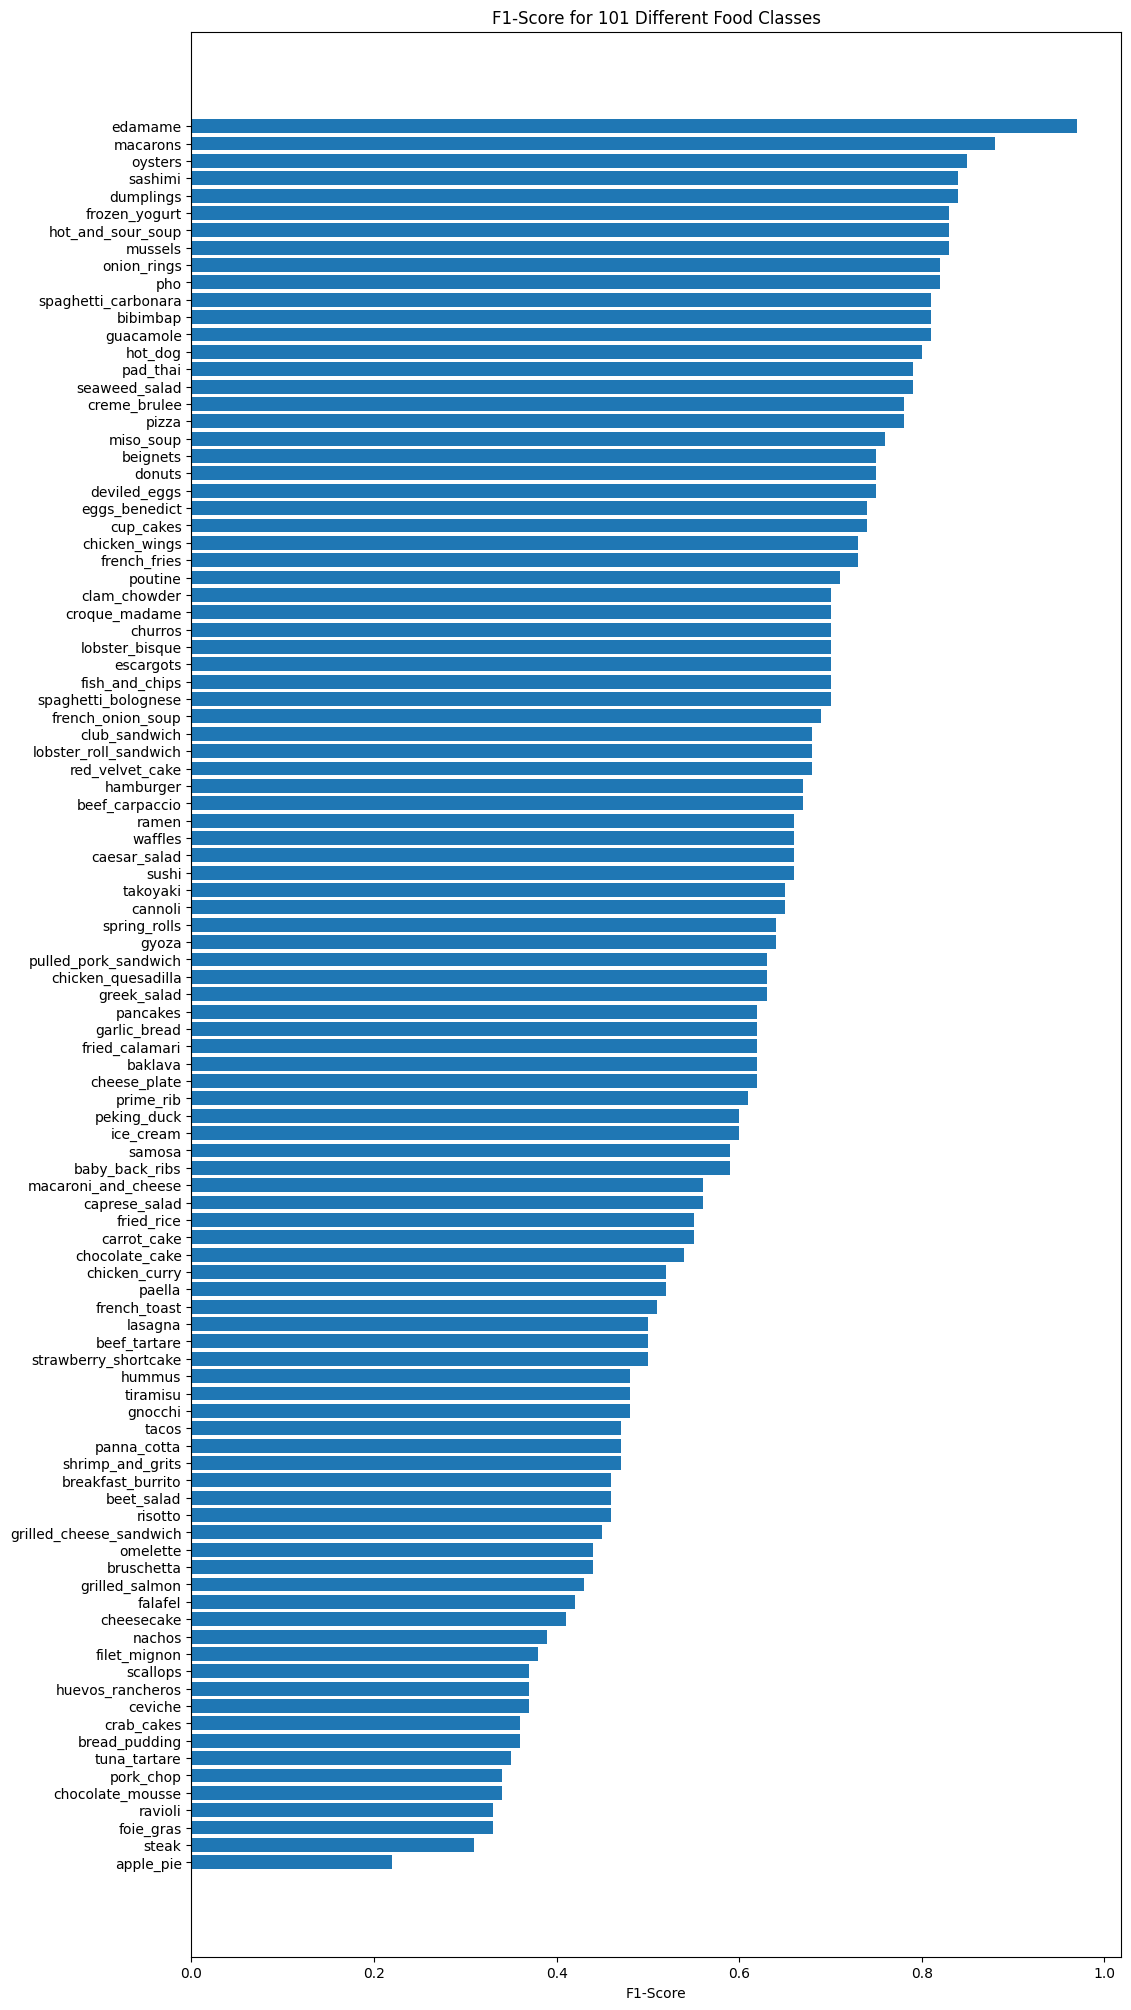

In [ ]:
# Visualize the f1-score
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores_df)), f1_scores_df['f1-score'].values) # get f1-score values
ax.set_yticks(range(len(f1_scores_df)))
ax.set_yticklabels(f1_scores_df['class_name'])
ax.set_xlabel('F1-Score')
ax.set_title('F1-Score for 101 Different Food Classes')
ax.invert_yaxis(); # reverse the plot

## Visualizing predicitons on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset.

To visualize model's predicitions on our own imges, we'll need a fuction to load and preprocess images, specifically it will need to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scake tge şnage tı get all of pixel values between 0 and 1.

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
    '''
    Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels=3).

    Args:
        filename (str): path to target image
        image_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1

    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    '''
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode the image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale the images
    if scale:
        # Rescale the image
        return img / 255.
    else:
        return img # Due to its built-in scaling, EfficientNet doesn't need to be scaled

Now, we've got a function to load and prepare target images, let's now wirte some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original images along with the model's predictions, prediction probability and label

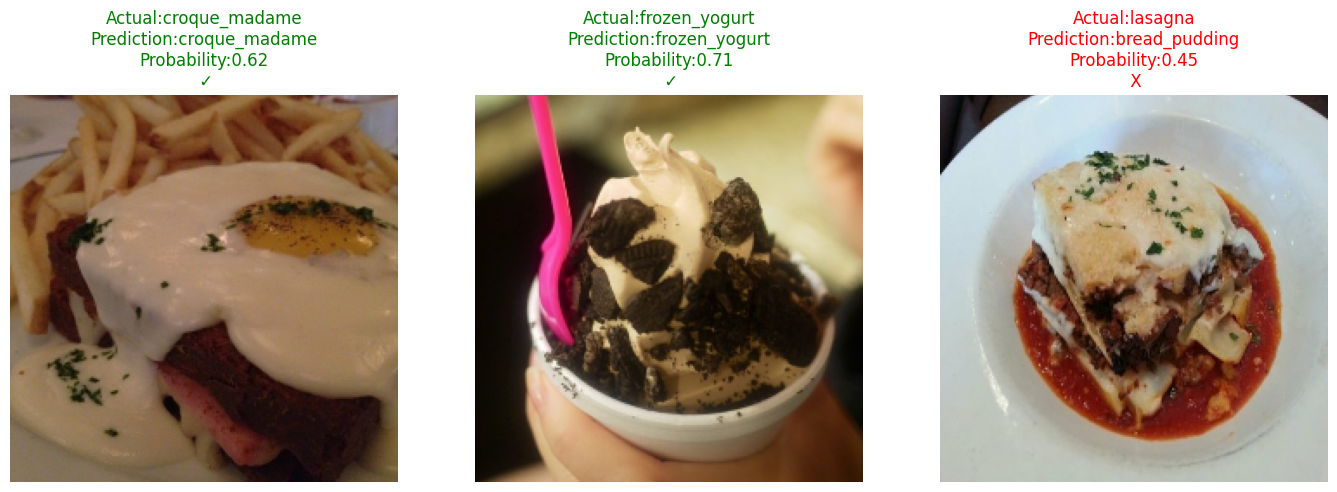

In [ ]:
# Make preds on a series of random images
plt.figure(figsize=(17, 10))
for i in range(3):
    # Chose random images from a random classes
    class_name = random.choice(test_data.class_names)
    filename = random.choice(os.listdir(test_dir + '/' + class_name))
    filepath = test_dir + class_name + '/' + filename

    # Load image an make predictions
    img = load_and_prep_image(filepath, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = test_data.class_names[pred_prob.argmax()]

    # Plot the images and probabilities and labels
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # if predicted class match with actual class, make green text
        plt.title(f'Actual:{class_name}\nPrediction:{pred_class}\nProbability:{pred_prob.max():.2f}\n ✓', c='g')
    else:
        plt.title(f'Actual:{class_name}\nPrediction:{pred_class}\nProbability:{pred_prob.max():.2f}\n X', c='r')
    plt.axis(False);

## Finding the most wrong predictions

To find out where the model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using the list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, ğredicted classes (from out model), max prediction probabilities.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the dataframe based on wrong prediction (have the highest predition probabilitu predictions at the top)
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths = []

for filepath in test_data.list_files('101_food_classes_10_percent/test/*/*.jpg',
                                    shuffle=False):
    filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred_class': pred_classes,
                        'pred_conf': preds_probs.max(axis=1),
                        'y_true_class_name': [test_data.class_names[i] for i in y_labels],
                        'y_pred_class_name': [test_data.class_names[i] for i in pred_classes]})

pred_df

img_path  y_true  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0   
...                                                  ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100   
25247  b'101_food_classes_10_percent/test/waffles/961...     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100   
25249  b'101_food_classes_10_percent/test/waffles/971...     100   

       y_pred_class  pred_conf y_true_class_name     y_pred_class_name  
0                28   0.274191         apple_pie         croque_madame  
1                 0   0.938399         apple_pie             apple_pie  
2                 0   0.467938         apple_pie             apple_pie  
3                 8   0.267266         apple_pie         bread_pudding  
4                 8   0.531543         apple_pie         bread_pudding  
...             ...        ...               ...                   ...  
25245           100   0.983950           waffles               waffles  
25246            16   0.866385           waffles          cheese_plate  
25247           100   0.374461           waffles               waffles  
25248            94   0.289745           waffles  strawberry_shortcake  
25249           100   0.619921           waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df['pred_correnct'] = pred_df['y_true'] == pred_df['y_pred_class']
pred_df

img_path  y_true  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0   
...                                                  ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100   
25247  b'101_food_classes_10_percent/test/waffles/961...     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100   
25249  b'101_food_classes_10_percent/test/waffles/971...     100   

       y_pred_class  pred_conf y_true_class_name     y_pred_class_name  \
0                28   0.274191         apple_pie         croque_madame   
1                 0   0.938399         apple_pie             apple_pie   
2                 0   0.467938         apple_pie             apple_pie   
3                 8   0.267266         apple_pie         bread_pudding   
4                 8   0.531543         apple_pie         bread_pudding   
...             ...        ...               ...                   ...   
25245           100   0.983950           waffles               waffles   
25246            16   0.866385           waffles          cheese_plate   
25247           100   0.374461           waffles               waffles   
25248            94   0.289745           waffles  strawberry_shortcake   
25249           100   0.619921           waffles               waffles   

       pred_correnct  
0              False  
1               True  
2               True  
3              False  
4              False  
...              ...  
25245           True  
25246          False  
25247           True  
25248          False  
25249           True  

[25250 rows x 7 columns]

In [ ]:
# Sort our dataframe by most wrong predictions
top_100_wrong = pred_df[pred_df['pred_correnct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong

img_path  y_true  \
11642  b'101_food_classes_10_percent/test/garlic_brea...      46   
21810  b'101_food_classes_10_percent/test/scallops/17...      87   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72   
...                                                  ...     ...   
11898  b'101_food_classes_10_percent/test/gnocchi/340...      47   
16611  b'101_food_classes_10_percent/test/nachos/2704...      66   
179    b'101_food_classes_10_percent/test/apple_pie/3...       0   
10289  b'101_food_classes_10_percent/test/french_onio...      41   
18807  b'101_food_classes_10_percent/test/pho/1713987...      75   

       y_pred_class  pred_conf  y_true_class_name    y_pred_class_name  \
11642            10   0.998663       garlic_bread           bruschetta   
21810            29   0.998039           scallops            cup_cakes   
191              31   0.997408          apple_pie               donuts   
15142            64   0.997309     lobster_bisque            miso_soup   
18001            67   0.996777           pancakes             omelette   
...             ...        ...                ...                  ...   
11898            87   0.967485            gnocchi             scallops   
16611             9   0.967418             nachos    breakfast_burrito   
179               8   0.966473          apple_pie        bread_pudding   
10289            62   0.966221  french_onion_soup  macaroni_and_cheese   
18807            98   0.965781                pho             tiramisu   

       pred_correnct  
11642          False  
21810          False  
191            False  
15142          False  
18001          False  
...              ...  
11898          False  
16611          False  
179            False  
10289          False  
18807          False  

[100 rows x 7 columns]

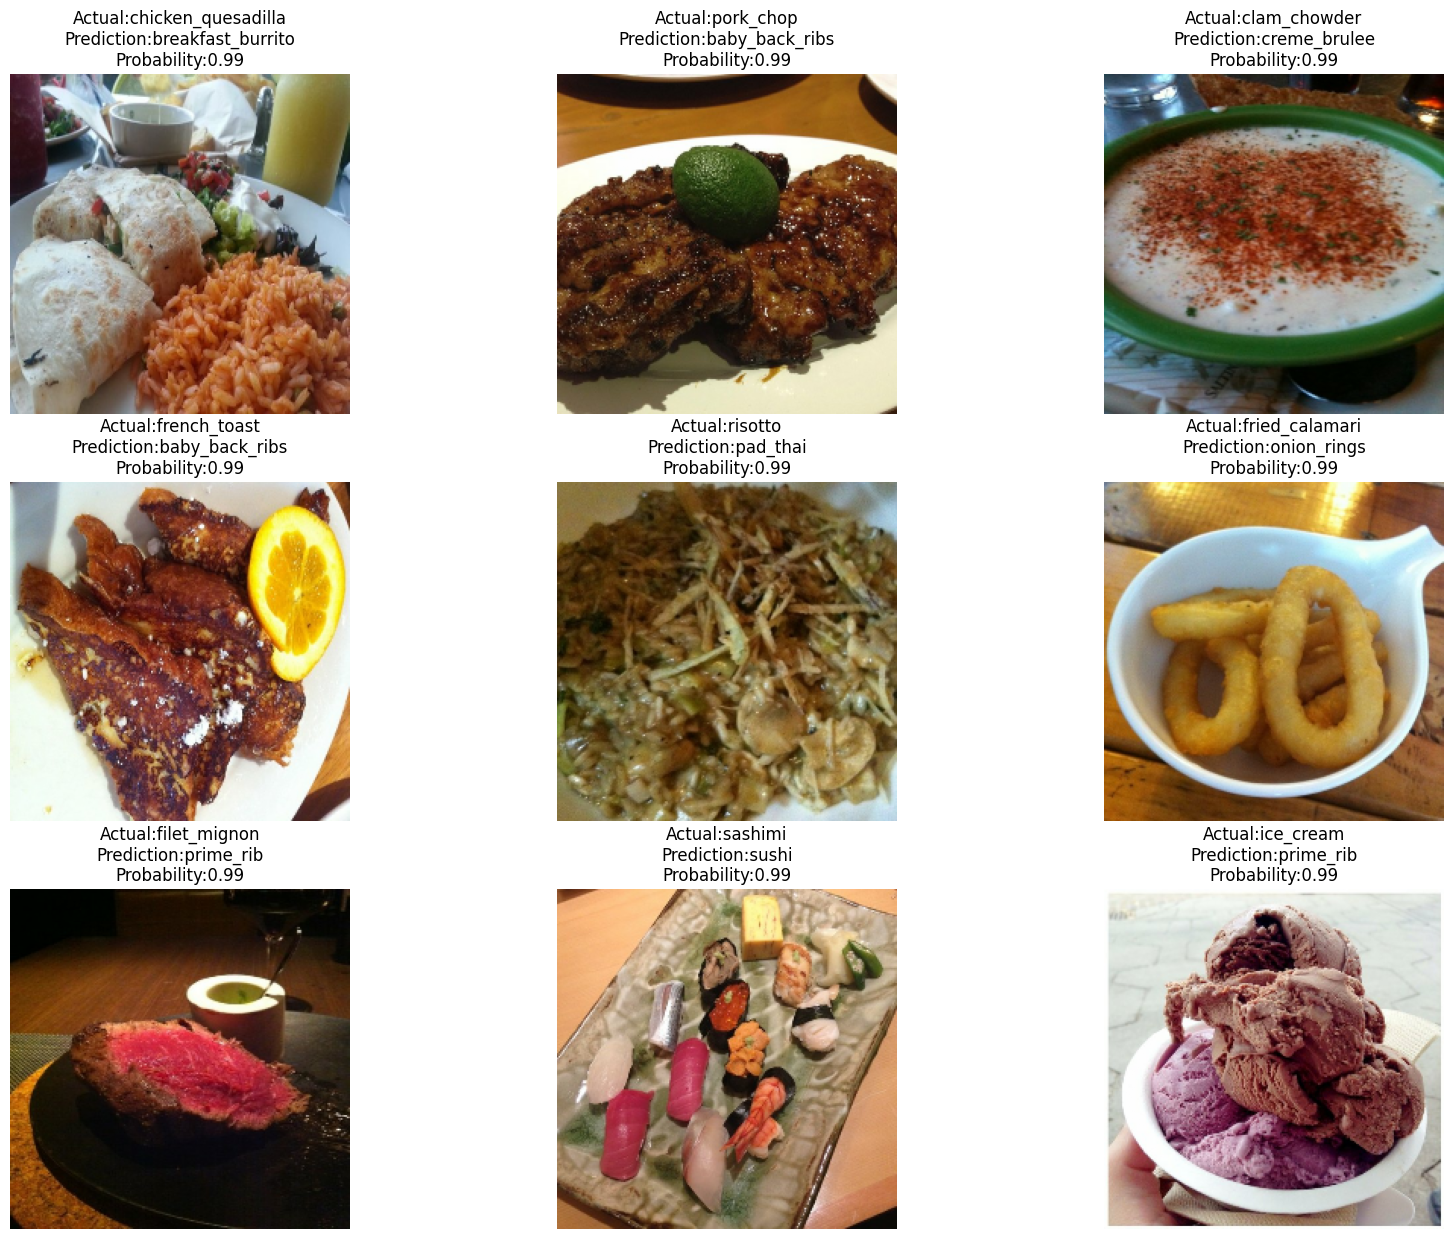

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 10
plt.figure(figsize=(20, 15))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
    plt.imshow(img/255.)
    plt.title(f'Actual:{y_true_classname}\nPrediction:{y_pred_classname}\nProbability:{pred_prob:.2f}')
    plt.axis(False);

## Test the model on our custom image and plot it

In [ ]:
# Get custom image
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

zip_ref = zipfile.ZipFile('custom_food_images.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-17 17:32:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  11.6MB/s    in 1.1s    

2023-07-17 17:32:53 (11.6 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom food images filepath
custom_food_images = ['custom_food_images/' + i  for i in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg']

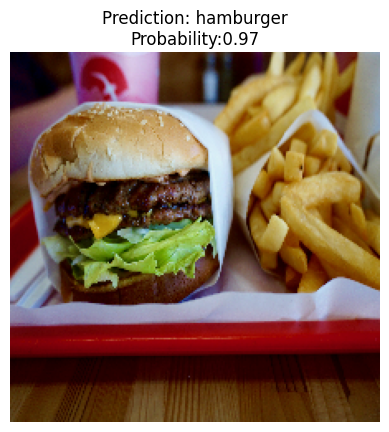

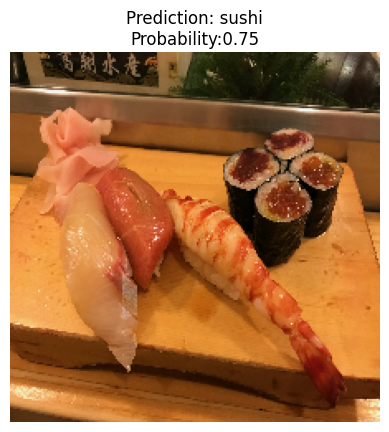

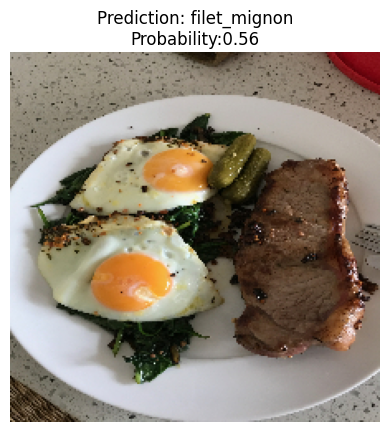

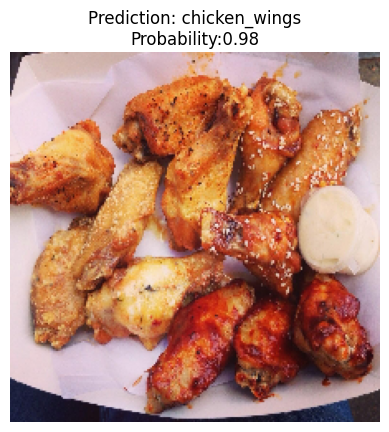

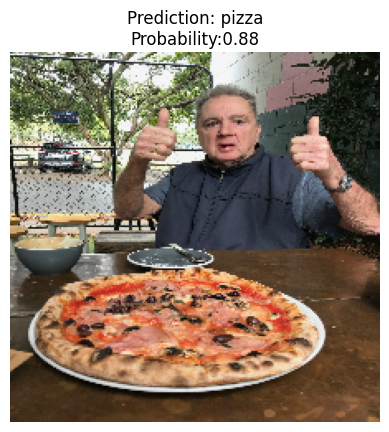

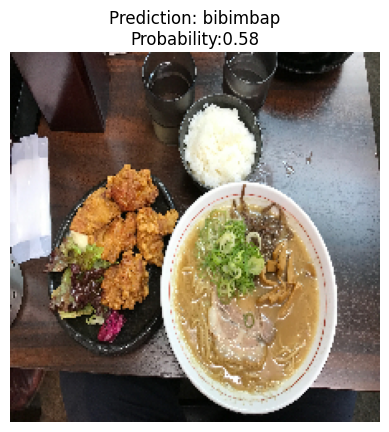

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
    img = load_and_prep_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = test_data.class_names[pred_prob.argmax()]
    # Plot
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f'Prediction: {pred_class}\nProbability:{pred_prob.max():.2f}')
    plt.axis(False)